# Creating Figures Strong Corr

## Creating Panel B

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename

from lib.file_utils import get_dms_pfc_paths_mono
from lib.calculation import get_response_bg_firing
from lib.figure_5 import fig_5_panel_b

mono_pairs = get_dms_pfc_paths_mono()

for ind, row in mono_pairs.iterrows():
    behaviour_data = pd.read_csv(row['session_path'])
    pfc_times = np.load(row['pfc_path'])
    str_times = np.load(row['dms_path'])

    session_name = basename(row['session_path']).split('.')[0]
    pfc_name = basename(row['pfc_path']).split('.')[0]
    str_name = basename(row['dms_path']).split('.')[0]
    fig_name = '_'.join([session_name, pfc_name, str_name, 'iti']) + '.png'
    fig_path = pjoin('figures', 'figure_5', 'panel_b', fig_name)

    cue_times = behaviour_data['cue_time'].tolist()
    pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
    str_mag, str_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)

    fig = fig_5_panel_b(pfc_mag, str_mag)
    fig.savefig(fig_path, dpi=300)
    plt.close()

## Panel C Mono

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename

from lib.file_utils import get_dms_pfc_paths_mono
from lib.figure_5 import fig_5_panel_c, phase_diff_pfc_dms
from lib.calculation import get_response_bg_firing

mono_pairs = get_dms_pfc_paths_mono()

phase_diffs = []
phase_diffs_bg = [] 
for ind, row in mono_pairs.iterrows():
    behaviour_data = pd.read_csv(row['session_path'])
    pfc_times = np.load(row['pfc_path'])
    str_times = np.load(row['str_path'])

    cue_times = behaviour_data['cue_time'].tolist()
    pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
    str_mag, str_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)

    phase_d, phase_d_bg = phase_diff_pfc_dms(pfc_mag=pfc_mag, pfc_bg=pfc_bg, dms_mag=str_mag, dms_bg=str_bg)
    phase_diffs.append(phase_d)
    phase_diffs_bg.append(phase_d_bg)

fig_path = pjoin('figures', 'figure_5', 'panel_c', 'mono_all.jpg')
fig = fig_5_panel_c(phase_diffs=phase_diffs, phase_diffs_bg=phase_diffs_bg, bin_size=36)
fig.savefig(fig_path, dpi=300)

## Panel D Mono

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename

from lib.file_utils import get_dms_pfc_paths_mono
from lib.figure_5 import fig_5_panel_d, phase_diff_pfc_dms
from lib.calculation import get_session_performances, get_response_bg_firing

mono_pairs = get_dms_pfc_paths_mono()

# iti correlated
phase_diffs = []
phase_diffs_bg = []
phase_diffs_bad = []
phase_diffs_bg_bad = []
performances, cutoff = get_session_performances()
session_phase_diffs_positive_good = {}
session_phase_diffs_negative_good = {}
session_phase_diffs_positive_good_bg = {}
session_phase_diffs_negative_good_bg = {}
session_phase_diffs_positive_bad = {}
session_phase_diffs_negative_bad = {}
session_phase_diffs_positive_bad_bg = {}
session_phase_diffs_negative_bad_bg = {}
for ind, row in mono_pairs.iterrows():
    behaviour_data = pd.read_csv(row['session_path'])
    pfc_times = np.load(row['pfc_path'])
    str_times = np.load(row['dms_path'])

    session_name = basename(row['session_path']).split('.')[0]

    # create an entry for the session in the dictionary if it doesn't exist
    if session_name not in session_phase_diffs_positive_good.keys():
        session_phase_diffs_positive_good[session_name] = []
        session_phase_diffs_negative_good[session_name] = []
        session_phase_diffs_positive_bad[session_name] = []
        session_phase_diffs_negative_bad[session_name] = []
        session_phase_diffs_positive_good_bg[session_name] = []
        session_phase_diffs_negative_good_bg[session_name] = []
        session_phase_diffs_positive_bad_bg[session_name] = []
        session_phase_diffs_negative_bad_bg[session_name] = []

    cue_times = behaviour_data['cue_time'].tolist()
    pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
    dms_mag, dms_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)

    phase_d, phase_d_bg = phase_diff_pfc_dms(pfc_mag=pfc_mag, pfc_bg=pfc_bg, dms_mag=dms_mag, dms_bg=dms_bg)
    if performances[session_name] > cutoff:
        phase_diffs.append(phase_d)
        phase_diffs_bg.append(phase_d_bg)
        if phase_d > 0:
            session_phase_diffs_positive_good[session_name].append(phase_d)
        else:
            session_phase_diffs_negative_good[session_name].append(phase_d)
        if phase_d_bg > 0:
            session_phase_diffs_positive_good_bg[session_name].append(phase_d_bg)
        else:
            session_phase_diffs_negative_good_bg[session_name].append(phase_d_bg)
    else:
        phase_diffs_bad.append(phase_d)
        phase_diffs_bg_bad.append(phase_d_bg)
        if phase_d > 0:
            session_phase_diffs_positive_bad[session_name].append(phase_d)
        else:
            session_phase_diffs_negative_bad[session_name].append(phase_d)
        if phase_d_bg > 0:
            session_phase_diffs_positive_bad_bg[session_name].append(phase_d_bg)
        else:
            session_phase_diffs_negative_bad_bg[session_name].append(phase_d_bg)

# run the paired t test for each session for response magnitude and background firing between good and bad sessions
from scipy.stats import ttest_1samp # type: ignore
# calculate the number of pairs for each session
n_pairs_good_positive = []
n_pairs_good_negative = []
n_pairs_bad_positive = []
n_pairs_bad_negative = []
n_pairs_good_positive_bg = []
n_pairs_good_negative_bg = []
n_pairs_bad_positive_bg = []
n_pairs_bad_negative_bg = []
for session_name in session_phase_diffs_positive_good.keys():
    n_pairs_good_positive.append(len(session_phase_diffs_positive_good[session_name]))
    n_pairs_good_negative.append(len(session_phase_diffs_negative_good[session_name]))
    n_pairs_bad_positive.append(len(session_phase_diffs_positive_bad[session_name]))
    n_pairs_bad_negative.append(len(session_phase_diffs_negative_bad[session_name]))
    n_pairs_good_positive_bg.append(len(session_phase_diffs_positive_good_bg[session_name]))
    n_pairs_good_negative_bg.append(len(session_phase_diffs_negative_good_bg[session_name]))
    n_pairs_bad_positive_bg.append(len(session_phase_diffs_positive_bad_bg[session_name]))
    n_pairs_bad_negative_bg.append(len(session_phase_diffs_negative_bad_bg[session_name]))

n_pairs_good_positive = np.array(n_pairs_good_positive)
n_pairs_good_negative = np.array(n_pairs_good_negative)
n_pairs_bad_positive = np.array(n_pairs_bad_positive)
n_pairs_bad_negative = np.array(n_pairs_bad_negative)
n_pairs_good_positive_bg = np.array(n_pairs_good_positive_bg)
n_pairs_good_negative_bg = np.array(n_pairs_good_negative_bg)
n_pairs_bad_positive_bg = np.array(n_pairs_bad_positive_bg)
n_pairs_bad_negative_bg = np.array(n_pairs_bad_negative_bg)

# run the paired t test and record the p values
ttest_good_positive = ttest_1samp(n_pairs_good_positive - n_pairs_good_negative, 0, alternative='greater')
ttest_bad_positive = ttest_1samp(n_pairs_bad_positive - n_pairs_bad_negative, 0, alternative='greater')
ttest_good_positive_bg = ttest_1samp(n_pairs_good_positive_bg - n_pairs_good_negative_bg, 0, alternative='greater')
ttest_bad_positive_bg = ttest_1samp(n_pairs_bad_positive_bg - n_pairs_bad_negative_bg, 0, alternative='greater')

# print the results
print('ttest_good_positive: {}'.format(ttest_good_positive))
print('ttest_bad_positive: {}'.format(ttest_bad_positive))
print('ttest_good_positive_bg: {}'.format(ttest_good_positive_bg))
print('ttest_bad_positive_bg: {}'.format(ttest_bad_positive_bg))



fig_path = pjoin('figures', 'figure_5', 'panel_d', 'mono_all.jpg')
fig = fig_5_panel_d(phase_diffs=phase_diffs, phase_diffs_bg=phase_diffs_bg, phase_diffs_bad=phase_diffs_bad, phase_diffs_bg_bad=phase_diffs_bg_bad, bin_size=36)
# fig.savefig(fig_path, dpi=300)

## Panel C All

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename
from os import listdir

from lib.figure_5 import fig_5_panel_c, phase_diff_pfc_dms
from lib.calculation import get_session_performances, get_response_bg_firing

phase_diffs = []
phase_diffs_bg = [] 
bin_size = 100

performances, cutoff = get_session_performances()
spike_data_root = pjoin('data', 'spike_times', 'sessions')
behaviour_root = pjoin('data', 'behaviour_data')

for session_name in listdir(spike_data_root):
    behaviour = pjoin(behaviour_root, session_name + '.csv')
    behaviour_data = pd.read_csv(behaviour)
    cue_times = behaviour_data['cue_time'].tolist()
    for pfc in glob(pjoin(spike_data_root, session_name, 'pfc_*')):
        pfc_times = np.load(pfc)
        for dms in glob(pjoin(spike_data_root, session_name, 'str_*')):
            str_times = np.load(dms)
            pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
            dms_mag, dms_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)
            phase_d, phase_d_bg = phase_diff_pfc_dms(pfc_mag=pfc_mag, pfc_bg=pfc_bg, dms_mag=dms_mag, dms_bg=dms_bg)
            phase_diffs.append(phase_d)
            phase_diffs_bg.append(phase_d_bg)

fig = fig_5_panel_c(phase_diffs=phase_diffs, phase_diffs_bg=phase_diffs_bg, bin_size=36, zero_ymin=False)

## Panel D All

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename
from os import listdir
from tqdm import tqdm

from lib.figure_5 import fig_5_panel_d, phase_diff_pfc_dms
from lib.calculation import get_session_performances, get_response_bg_firing

phase_diffs = []
phase_diffs_bg = [] 
phase_diffs_bad = []   
phase_diffs_bg_bad = []
performances, cutoff = get_session_performances()
spike_data_root = pjoin('data', 'spike_times', 'sessions')
behaviour_root = pjoin('data', 'behaviour_data')

n_pairs_good_positive = []
n_pairs_good_negative = []
n_pairs_bad_positive = []
n_pairs_bad_negative = []
n_pairs_good_positive_bg = []
n_pairs_good_negative_bg = []
n_pairs_bad_positive_bg = []
n_pairs_bad_negative_bg = []

for session_name in tqdm(listdir(spike_data_root)):
    behaviour = pjoin(behaviour_root, session_name + '.csv')
    behaviour_data = pd.read_csv(behaviour)
    cue_times = behaviour_data['cue_time'].tolist()

    cur_positive = []
    cur_negative = []
    cur_positive_bg = []
    cur_negative_bg = []

    for pfc in glob(pjoin(spike_data_root, session_name, 'pfc_*')):
        pfc_times = np.load(pfc)
        pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
        for dms in glob(pjoin(spike_data_root, session_name, 'dms_*')):
            str_times = np.load(dms)
            str_mag, str_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)            
            phase_d, phase_d_bg = phase_diff_pfc_dms(pfc_mag=pfc_mag, pfc_bg=pfc_bg, dms_mag=str_mag, dms_bg=str_bg)
            if performances[session_name] > cutoff:
                phase_diffs.append(phase_d)
                phase_diffs_bg.append(phase_d_bg)
            else:
                phase_diffs_bad.append(phase_d)
                phase_diffs_bg_bad.append(phase_d_bg)
            if phase_d > 0:
                cur_positive.append(phase_d)
            else:
                cur_negative.append(phase_d)
            if phase_d_bg > 0:
                cur_positive_bg.append(phase_d_bg)
            else:
                cur_negative_bg.append(phase_d_bg)
    if performances[session_name] > cutoff:
        n_pairs_good_positive.append(len(cur_positive))
        n_pairs_good_negative.append(len(cur_negative))
        n_pairs_good_positive_bg.append(len(cur_positive_bg))
        n_pairs_good_negative_bg.append(len(cur_negative_bg))
    else:
        n_pairs_bad_positive.append(len(cur_positive))
        n_pairs_bad_negative.append(len(cur_negative))
        n_pairs_bad_positive_bg.append(len(cur_positive_bg))
        n_pairs_bad_negative_bg.append(len(cur_negative_bg))
        
# run the paired t test and report the p value
from scipy.stats import ttest_1samp # type: ignore

n_pairs_good_positive = np.array(n_pairs_good_positive)
n_pairs_good_negative = np.array(n_pairs_good_negative)
n_pairs_bad_positive = np.array(n_pairs_bad_positive)
n_pairs_bad_negative = np.array(n_pairs_bad_negative)
n_pairs_good_positive_bg = np.array(n_pairs_good_positive_bg)
n_pairs_good_negative_bg = np.array(n_pairs_good_negative_bg)
n_pairs_bad_positive_bg = np.array(n_pairs_bad_positive_bg)
n_pairs_bad_negative_bg = np.array(n_pairs_bad_negative_bg)
# run the paired t test and record the p values
ttest_good_positive = ttest_1samp(n_pairs_good_positive - n_pairs_good_negative, 0, alternative='greater')
ttest_bad_positive = ttest_1samp(n_pairs_bad_positive - n_pairs_bad_negative, 0, alternative='greater')
ttest_good_positive_bg = ttest_1samp(n_pairs_good_positive_bg - n_pairs_good_negative_bg, 0, alternative='greater')
ttest_bad_positive_bg = ttest_1samp(n_pairs_bad_positive_bg - n_pairs_bad_negative_bg, 0, alternative='greater')

# print the results
print('ttest_good_positive: {}'.format(ttest_good_positive))
print('ttest_bad_positive: {}'.format(ttest_bad_positive))
print('ttest_good_positive_bg: {}'.format(ttest_good_positive_bg))
print('ttest_bad_positive_bg: {}'.format(ttest_bad_positive_bg))


fig = fig_5_panel_d(phase_diffs=phase_diffs, phase_diffs_bg=phase_diffs_bg, phase_diffs_bad=phase_diffs_bad, phase_diffs_bg_bad=phase_diffs_bg_bad, bin_size=36, zero_ymin=False)

100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


PFC response: 0.21261826243426896 0.007537450972323834
PFC bg: -2.2594842676390936 0.872310552817521
DMS response: -1.4993242018769848 0.037689351183636366
DMS bg: -2.503062904119429 0.15666067096275627
PFC response: 1555 / 1668
PFC bg: 422 / 1668
DMS response: 332 / 974
DMS bg: 264 / 974


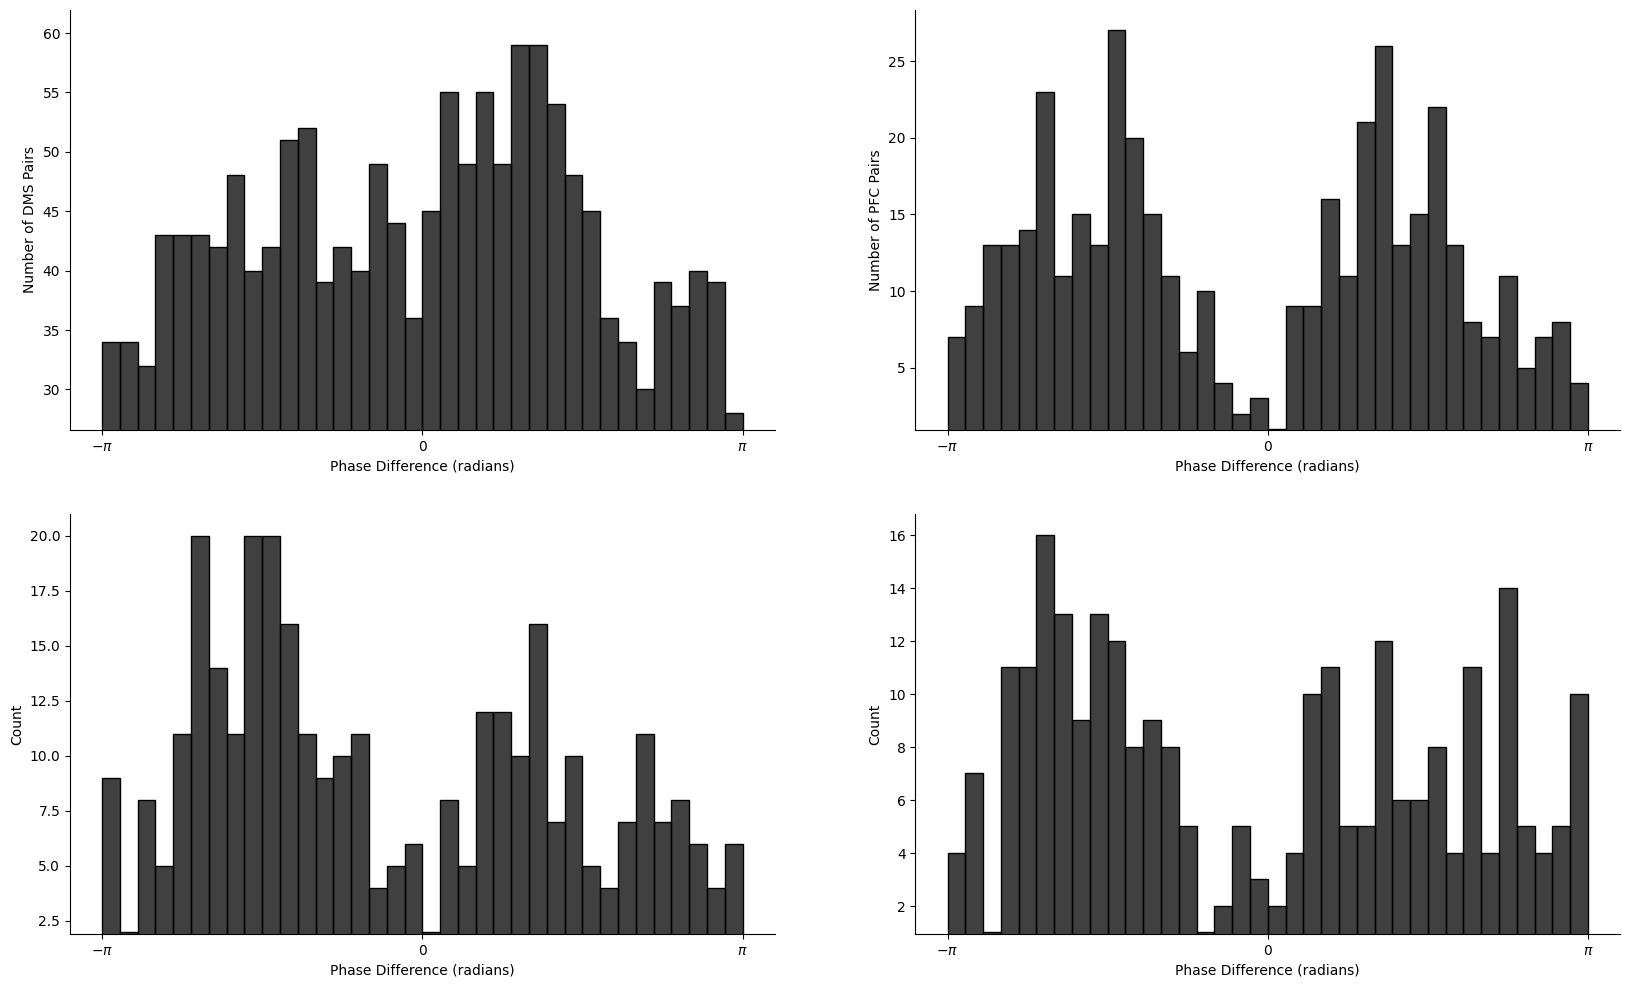

In [1]:
from lib.figure_5 import get_figure_5_panel_e

get_figure_5_panel_e(mono=False, no_nan=False)